<a href="https://colab.research.google.com/github/maty91ok/Licienciatura-Ciencia-de-Datos/blob/main/Final_trabajo_practico_Mat%C3%ADas_Canevaro_v0_0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico Final – Pipeline de Procesamiento de Imágenes
**Versión generada por asistente:** 2025-11-05 02:55

Este notebook implementa de punta a punta los puntos requeridos:
1. Estructura de directorios y setup
2. Funciones auxiliares (carga, muestreo y visualización)
3. Clasificación de figuras en subdirectorios por clase
4. Redimensionado 800×800
5. Conversión a blanco y negro
6. Recorte de filas/columnas vacías (crop de borde)
7. Fondo transparente
8. Colorear figura según clase
9. Marcar puntos extremos + rotular clase
10. Gráfico de barras por categoría

> **Nota de dependencias**: se utiliza principalmente `numpy`, `Pillow` y `matplotlib`. Opcionalmente `opencv-python` (`cv2`) para detección de contornos. Si no lo tenés, instalalo con `pip install opencv-python`. El código maneja un *fallback* simple sin OpenCV, pero se recomienda tenerlo para mejores resultados.


## Punto 1: Entorno de trabajo – estructura de directorios

In [18]:
# =========================================================
# TRABAJO PRÁCTICO FINAL – PIPELINE DE PROCESAMIENTO DE IMÁGENES
# =========================================================

# --- LIBRERÍAS BASE ---
from pathlib import Path
import shutil, random, os, zipfile, requests
import numpy as np
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt

# --- CREAR ESTRUCTURA DE CARPETAS ---
ROOT = Path('/content/tp_final')
DATA = ROOT / 'data'
RAW = DATA / 'raw' / 'geometric_figures'
INTERIM = DATA / 'interim' / 'geometric_figures'
PROCESSED = DATA / 'processed' / 'geometric_figures'

for p in [ROOT, DATA, RAW, INTERIM, PROCESSED]:
    p.mkdir(parents=True, exist_ok=True)

print("📂 Estructura creada en:", ROOT.resolve())
print("⬇️ Colocá aquí el ZIP de imágenes (si lo bajás manualmente):", RAW.resolve())

# --- DESCARGAR AUTOMÁTICAMENTE imgs.zip si no existe ---
zip_path = "/content/imgs.zip"
if not Path(zip_path).exists():
    url = "https://github.com/HAD141/datasets/raw/refs/heads/main/Finales/v0.0.4/imgs.zip"
    print("🌐 Descargando dataset desde GitHub...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)
    print("✅ Descarga completa:", zip_path)
else:
    print("📦 Dataset ya encontrado:", zip_path)

# --- DESCOMPRIMIR imgs.zip ---
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(RAW)
print("✅ Dataset descomprimido correctamente en:", RAW)



📂 Estructura creada en: /content/tp_final
⬇️ Colocá aquí el ZIP de imágenes (si lo bajás manualmente): /content/tp_final/data/raw/geometric_figures
🌐 Descargando dataset desde GitHub...
✅ Descarga completa: /content/imgs.zip
✅ Dataset descomprimido correctamente en: /content/tp_final/data/raw/geometric_figures


In [19]:
import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFont
import matplotlib.pyplot as plt

try:
    import cv2
    HAS_CV2 = True
except Exception:
    cv2 = None
    HAS_CV2 = False

def list_images(folder: Path):
    exts = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}
    return [p for p in folder.rglob('*') if p.suffix.lower() in exts]


## Punto 2: Funciones auxiliares – muestreo y visualización

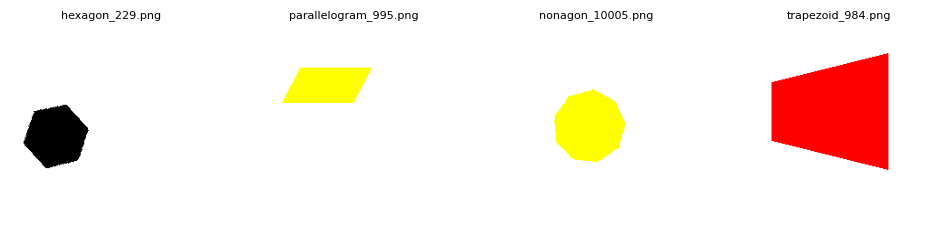

In [20]:
def show_random_images(folder: Path, n=4, seed=42):
    imgs = list_images(folder)
    if not imgs:
        print('No hay imágenes en', folder)
        return
    random.Random(seed).shuffle(imgs)
    sel = imgs[:min(n, len(imgs))]
    cols = min(4, len(sel))
    plt.figure(figsize=(3*cols, 3))
    for i, p in enumerate(sel, 1):
        try:
            im = Image.open(p).convert('RGB')
            plt.subplot(1, cols, i)
            plt.imshow(im)
            plt.title(p.name, fontsize=8)
            plt.axis('off')
        except Exception as e:
            print('Error abriendo', p, e)
    plt.show()

# Vista rápida si ya hay imágenes en RAW
show_random_images(RAW, n=4)

## Helpers de clasificación de figuras

In [21]:
def classify_shape_pil(im: Image.Image):
    """Fallback simple sin OpenCV.
    - Binariza
    - Usa bounding box y proporciones para distinguir *aproximadamente* círculo/cuadrado/rectángulo/triángulo
    """
    gray = ImageOps.grayscale(im)
    arr = np.array(gray)
    thr = (arr > arr.mean()).astype(np.uint8)  # fondo claro vs figura oscura o viceversa
    # Invertir si la figura parece clara
    if thr.mean() > 0.5:
        thr = 1 - thr
    ys, xs = np.where(thr == 1)
    if len(xs) < 10:
        return 'unknown'
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    w = x1 - x0 + 1
    h = y1 - y0 + 1
    aspect = w / h
    # Muy aproximado
    if 0.9 <= aspect <= 1.1:
        # círculo o cuadrado: circularidad aproximada usando área vs bbox
        area = thr.sum()
        box_area = w*h
        fill_ratio = area/box_area
        return 'circle' if fill_ratio < 0.7 else 'square'
    else:
        return 'rectangle'


In [22]:
def classify_shape_cv(im: Image.Image):
    """Clasificación usando contornos + aproximación poligonal con OpenCV."""
    if not HAS_CV2:
        return classify_shape_pil(im)
    arr = np.array(im.convert('BGR')) if hasattr(cv2, 'COLOR_RGB2BGR') else np.array(im)
    if arr.ndim == 3:
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    else:
        gray = arr
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Asegurar figura blanca
    if th.mean() > 127:
        th = 255 - th
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return 'unknown'
    c = max(cnts, key=cv2.contourArea)
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True)
    v = len(approx)
    if v == 3:
        return 'triangle'
    if v == 4:
        x,y,w,h = cv2.boundingRect(approx)
        aspect = w/float(h)
        return 'square' if 0.9 <= aspect <= 1.1 else 'rectangle'
    if v == 5:
        return 'pentagon'
    if v == 6:
        return 'hexagon'
    # circularidad
    area = cv2.contourArea(c)
    if peri == 0:
        return 'unknown'
    circularity = 4*np.pi*area/(peri*peri)
    return 'circle' if circularity > 0.75 else 'star' if v > 6 else 'unknown'


In [23]:
def classify_shape(im: Image.Image):
    try:
        return classify_shape_cv(im)
    except Exception:
        return classify_shape_pil(im)


## Punto 3: Clasificación – copiar a `interim/03_classified/<clase>`

Clasificación terminada → /content/tp_final/data/interim/geometric_figures/03_classified


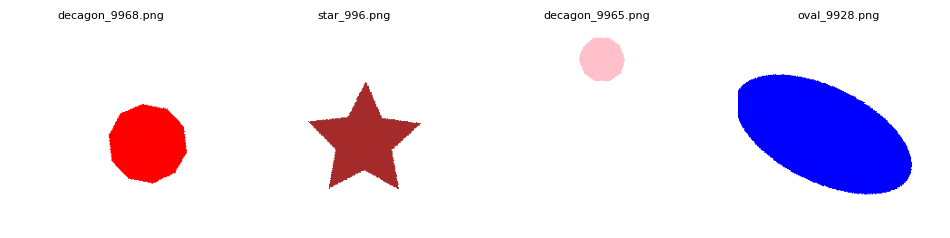

In [24]:
DEST3 = INTERIM / '03_classified'
DEST3.mkdir(parents=True, exist_ok=True)

def classify_all(raw_dir=RAW, out_dir=DEST3):
    imgs = list_images(raw_dir)
    if not imgs:
        print('No hay imágenes en RAW. Colocá el dataset en', raw_dir)
        return
    for p in imgs:
        try:
            im = Image.open(p).convert('RGBA')
            cls = classify_shape(im)
            target = out_dir / cls
            target.mkdir(parents=True, exist_ok=True)
            shutil.copy2(p, target / p.name)
        except Exception as e:
            print('Error con', p, e)
    print('Clasificación terminada →', out_dir)

classify_all()
show_random_images(DEST3, n=4)

## Helpers de transformación

In [25]:
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def save_image(im: Image.Image, path: Path):
    ensure_dir(path.parent)
    im.save(path)

def resize_im(im: Image.Image, size=(800,800)):
    return im.resize(size, Image.LANCZOS)

def to_bw(im: Image.Image):
    return ImageOps.grayscale(im).convert('1')  # binaria

def crop_empty_border(im: Image.Image, bg_threshold=250):
    # Recorta bordes casi blancos
    gray = ImageOps.grayscale(im)
    arr = np.array(gray)
    mask = arr < bg_threshold
    if mask.any():
        ys, xs = np.where(mask)
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()
        return im.crop((x0, y0, x1+1, y1+1))
    return im

def white_to_transparent(im: Image.Image, thr=240):
    rgba = im.convert('RGBA')
    arr = np.array(rgba)
    r,g,b,a = arr[:,:,0], arr[:,:,1], arr[:,:,2], arr[:,:,3]
    white = (r>thr)&(g>thr)&(b>thr)
    a[white] = 0
    arr[:,:,3] = a
    return Image.fromarray(arr)

COLOR_MAP = {
    'circle': '#1f77b4',
    'triangle': '#ff7f0e',
    'square': '#2ca02c',
    'rectangle': '#d62728',
    'pentagon': '#9467bd',
    'hexagon': '#8c564b',
    'star': '#e377c2',
    'unknown': '#7f7f7f'
}

def recolor_shape(im: Image.Image, cls: str):
    # Asume fondo claro, figura oscura → detecta figura por umbral
    color = COLOR_MAP.get(cls, '#7f7f7f')
    rgba = im.convert('RGBA')
    arr = np.array(rgba)
    gray = np.array(ImageOps.grayscale(im))
    thr = gray < gray.mean()  # figura=1 si es oscura
    # Si figura quedó al revés, invertir
    if thr.mean() < 0.5:
        thr = ~thr
    # Pintar la figura con el color elegido, mantener alfa
    import matplotlib.colors as mcolors
    r,g,b = mcolors.to_rgb(color)
    arr[thr, 0] = int(r*255)
    arr[thr, 1] = int(g*255)
    arr[thr, 2] = int(b*255)
    return Image.fromarray(arr)

def extrema_points(im: Image.Image):
    gray = ImageOps.grayscale(im)
    arr = np.array(gray)
    thr = arr < arr.mean()
    if thr.mean() < 0.5:
        thr = ~thr
    ys, xs = np.where(thr)
    if len(xs)==0:
        return None
    # extremos
    top = (xs[ys.argmin()], ys.min())
    bottom = (xs[ys.argmax()], ys.max())
    left = (xs.min(), ys[xs.argmin()])
    right = (xs.max(), ys[xs.argmax()])
    return {'top': top, 'bottom': bottom, 'left': left, 'right': right}

def draw_points_and_label(im: Image.Image, points: dict, label: str):
    im = im.convert('RGBA')
    draw = ImageDraw.Draw(im)
    for name, (x,y) in points.items():
        draw.ellipse((x-6, y-6, x+6, y+6), fill=(0,0,0,255))
    # rótulo
    draw.rectangle((10, 10, 10+8*len(label)+12, 36), fill=(255,255,255,180))
    draw.text((16, 14), label, fill=(0,0,0,255))
    return im


## Punto 4: Redimensionar imágenes a 800×800 → `interim/04_resized`

Redimensionado en /content/tp_final/data/interim/geometric_figures/04_resized


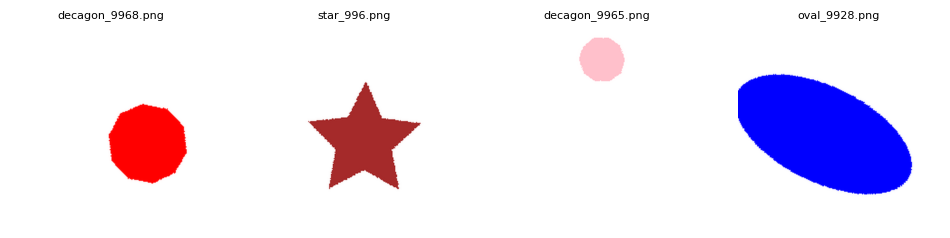

In [26]:
SRC = DEST3
DEST4 = INTERIM / '04_resized'
ensure_dir(DEST4)

def apply_resize(src=SRC, out=DEST4, size=(800,800)):
    for p in list_images(src):
        im = Image.open(p)
        outp = out / p.relative_to(src)
        save_image(resize_im(im, size), outp)
    print('Redimensionado en', out)

apply_resize()
show_random_images(DEST4, n=4)

## Punto 5: Blanco y negro → `interim/05_bw`

B/N en /content/tp_final/data/interim/geometric_figures/05_bw


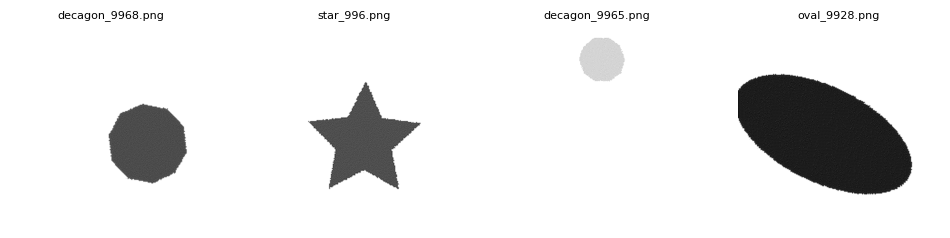

In [27]:
DEST5 = INTERIM / '05_bw'
ensure_dir(DEST5)

def apply_bw(src=DEST4, out=DEST5):
    for p in list_images(src):
        im = Image.open(p)
        outp = out / p.relative_to(src)
        save_image(to_bw(im), outp)
    print('B/N en', out)

apply_bw()
show_random_images(DEST5, n=4)

## Punto 6: Recorte de filas/columnas vacías → `interim/06_cropped`

Cropped en /content/tp_final/data/interim/geometric_figures/06_cropped


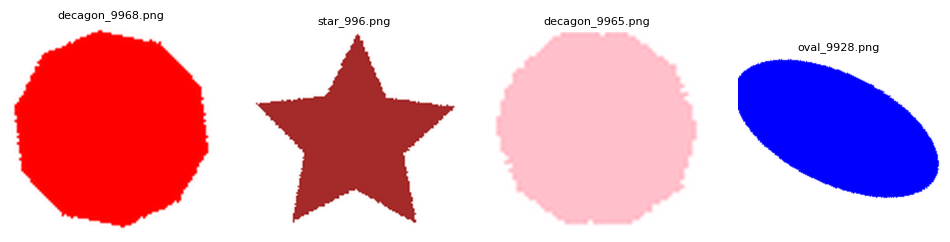

In [28]:
DEST6 = INTERIM / '06_cropped'
ensure_dir(DEST6)

def apply_crop(src=DEST4, out=DEST6):
    for p in list_images(src):
        im = Image.open(p)
        outp = out / p.relative_to(src)
        save_image(crop_empty_border(im), outp)
    print('Cropped en', out)

apply_crop()
show_random_images(DEST6, n=4)

## Punto 7: Fondo transparente → `interim/07_transparent_bg`

Fondo transparente en /content/tp_final/data/interim/geometric_figures/07_transparent_bg


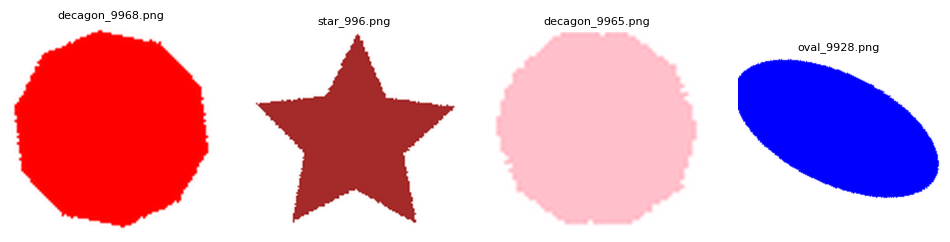

In [29]:
DEST7 = INTERIM / '07_transparent_bg'
ensure_dir(DEST7)

def apply_transparent_bg(src=DEST6, out=DEST7):
    for p in list_images(src):
        im = Image.open(p)
        outp = out / p.relative_to(src)
        save_image(white_to_transparent(im), outp.with_suffix('.png'))
    print('Fondo transparente en', out)

apply_transparent_bg()
show_random_images(DEST7, n=4)

## Punto 8: Colorear figura según clase → `processed/08_colored`

Recolor en /content/tp_final/data/processed/geometric_figures/08_colored


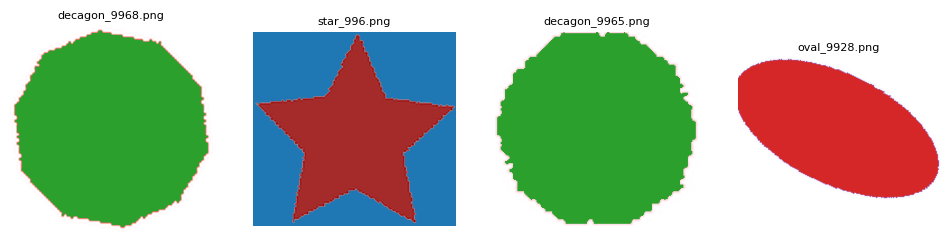

In [30]:
DEST8 = PROCESSED / '08_colored'
ensure_dir(DEST8)

def class_from_path(p: Path, base=DEST3):
    # Busca el nombre de clase en la parte del path relativa a DEST3
    parts = p.relative_to(base).parts
    return parts[0] if parts else 'unknown'

def apply_recolor(src=DEST6, reference_for_class=DEST3, out=DEST8):
    for p in list_images(src):
        # Mapear al path equivalente en DEST3 para leer la clase (por carpeta)
        try:
            rel = p.relative_to(src)
            cls_path = DEST3 / rel
            cls = class_from_path(cls_path, base=DEST3)
        except Exception:
            cls = 'unknown'
        im = Image.open(p).convert('RGBA')
        recol = recolor_shape(im, cls)
        outp = out / rel
        save_image(recol, outp.with_suffix('.png'))
    print('Recolor en', out)

apply_recolor()
show_random_images(DEST8, n=4)

## Punto 9: Marcar extremos + rotular clase → `processed/09_extreme_points`

Marcado de extremos en /content/tp_final/data/processed/geometric_figures/09_extreme_points


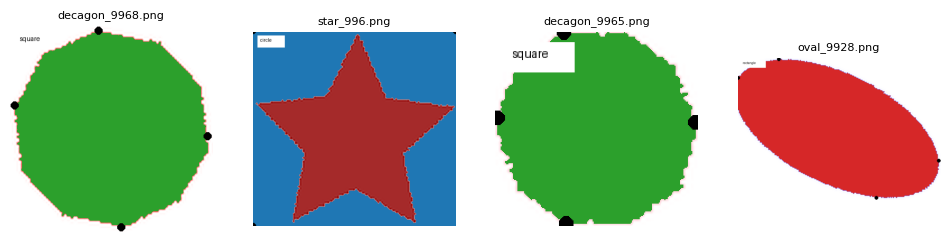

In [31]:
DEST9 = PROCESSED / '09_extreme_points'
ensure_dir(DEST9)

def apply_extrema_and_label(src=DEST8, out=DEST9):
    for p in list_images(src):
        im = Image.open(p).convert('RGBA')
        # Clase según carpeta en DEST8 (misma estructura que DEST3)
        cls = p.relative_to(src).parts[0] if p.relative_to(src).parts else 'unknown'
        pts = extrema_points(im)
        if pts is not None:
            im2 = draw_points_and_label(im, pts, cls)
        else:
            im2 = im
        outp = out / p.relative_to(src)
        save_image(im2, outp)
    print('Marcado de extremos en', out)

apply_extrema_and_label()
show_random_images(DEST9, n=4)

## Punto 10: Gráfico de barras por categoría (ordenado de menor a mayor)

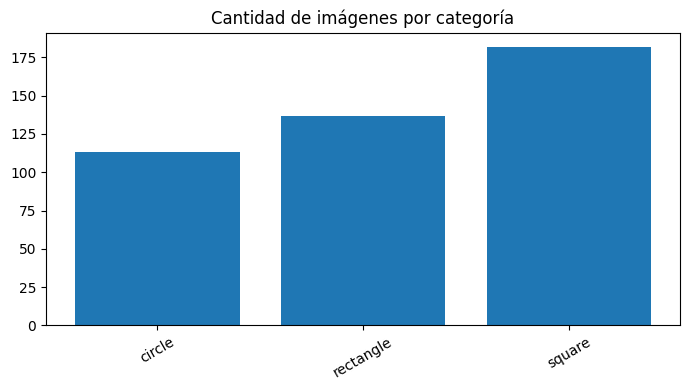

In [32]:
from collections import Counter

def count_by_class(folder: Path):
    counts = Counter()
    for p in list_images(folder):
        parts = p.relative_to(folder).parts
        if parts:
            counts[parts[0]] += 1
    return counts

counts = count_by_class(DEST9)
if counts:
    cats, vals = zip(*sorted(counts.items(), key=lambda kv: kv[1]))
    plt.figure(figsize=(7,4))
    plt.bar(cats, vals)
    plt.xticks(rotation=30)
    plt.title('Cantidad de imágenes por categoría')
    plt.tight_layout()
    plt.show()
else:
    print('No hay imágenes procesadas en', DEST9)